In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('../peptidome.mplstyle')

import sys
sys.path.append('..')
from lib import *

In [19]:
df = load_proteome_as_df('Human')
print('multiple seqs', len(df['Sequence'])-len(df['Sequence'].unique()))
df.drop_duplicates(subset=['Sequence'], inplace=True)

df_clustered = load_proteome_as_df_path(datadir+'cluster/UP000005640Human_rep_seq.fasta')
print('>.9 identity', len(df)-len(df_clustered),
      '%e'%(np.sum(df['Sequence'].str.len())-np.sum(df_clustered['Sequence'].str.len())))
df = df_clustered

multiple seqs 66
>.9 identity 1289 4.566740e+05


In [14]:
def counter_to_series(counter):
    count_df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    count_series = count_df.T.squeeze()
    return count_series
def fraction_multiple(series):
    return np.sum(series[series>1])/np.sum(series)

In [15]:
k = 9
filterlength = 12

In [16]:
count_series = counter_to_series(count_kmers_iterable(df['Sequence'], k, clean=True))
fraction_multiple(count_series)

0.08191076940880623

In [6]:
count_series_unique = counter_to_series(
                       count_kmers_iterable(
                           filter_unique(df['Sequence'], k, filterlength),
                           k)
                       )
fraction_multiple(count_series_unique)

0.02952183266376662

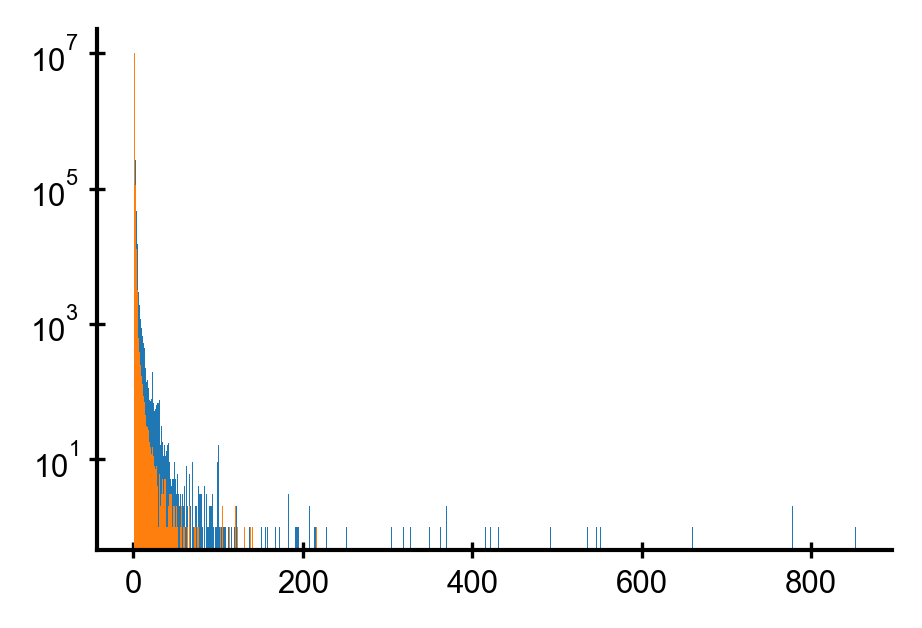

In [7]:
counts, bins, _ = plt.hist(count_series, log=True,
                           bins=np.arange(0, count_series.max()+1, 1));
plt.hist(count_series_unique, log=True, bins=bins);
#plt.xscale('log')

In [8]:
'{:.3e}, {:.3e}'.format(np.sum(count_series), np.sum(count_series_unique))

'1.089e+07, 1.045e+07'

In [9]:
count_series.sort_values().tail(10)

RTHTGEKPY    421
HQRIHTGEK    430
SSSSSSSSS    492
EEEEEEEEE    535
IHTGEKPYK    546
AAAAAAAAA    551
HTGEKPYEC    659
QQQQQQQQQ    777
RIHTGEKPY    777
HTGEKPYKC    853
Name: count, dtype: int64

In [10]:
count_series_unique.sort_values().tail(10)

HTGEKPYEC    105
GGGGGGGGG    113
KCEECGKAF    120
ECKECGKAF    120
RIHTGEKPY    122
SSSSSSSSS    131
QQQQQQQQQ    138
PPPPPPPPP    140
EEEEEEEEE    175
AAAAAAAAA    216
Name: count, dtype: int64